# 1. Import bibliotek

In [25]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# 2. Wczytanie danych

In [26]:

df = pd.read_csv("zbior_3_clean.csv")

# 3. Przygotowanie targetu i cech


In [ ]:

target_col = "default"

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

if target_col in numeric_cols:
    numeric_cols.remove(target_col)
if target_col in categorical_cols:
    categorical_cols.remove(target_col)

X = df.drop(columns=[target_col])
y = df[target_col]



# Sprawdź problematyczne wartości
print("Sprawdzanie wartości inf i NaN:")
print(f"Inf values: {np.isinf(df.select_dtypes(include=[np.number])).sum().sum()}")
print(f"NaN values: {df.isnull().sum().sum()}")
print(f"Max values:\n{df.select_dtypes(include=[np.number]).max()}")
print(f"Min values:\n{df.select_dtypes(include=[np.number]).min()}")

Sprawdzanie wartości inf i NaN:
Inf values: 0
NaN values: 0
Max values:
formaWlasnosci_Symbol             3.380000e+02
pkdKod                            9.609000e+03
wsk_liczba_dni_istnienia          1.659100e+04
Aktywa                            5.624976e+09
Aktywa_trwale                     3.895123e+09
                                      ...     
wsk_zast_kapitalu_podstawowego    2.135680e+05
wsk_sytuacji_fin                  8.728535e+06
wsk_struktura_kap_wlasnego_s_2    5.848597e+03
wsk_fin_majatku_kapitalem         1.000000e+05
default                           1.000000e+00
Length: 69, dtype: float64
Min values:
formaWlasnosci_Symbol                 0.000000
pkdKod                                0.000000
wsk_liczba_dni_istnienia           1184.000000
Aktywa                                0.000000
Aktywa_trwale                         0.000000
                                      ...     
wsk_zast_kapitalu_podstawowego     -401.371200
wsk_sytuacji_fin                     -0.010

# 4. Inicjalizacja modelu i walidacji

In [28]:
model = DecisionTreeClassifier(
    max_depth=5,           # Ograniczenie głębokości dla interpretowalności
    min_samples_split=20,  # Min. próbek do podziału węzła
    min_samples_leaf=10,   # Min. próbek w liściu
    random_state=42
)

# 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols)
    ])

# Pipeline: standardScaler nie jest potrzebny dla drzew, ale można zostawić
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('tree', model)
])

# 5. Walidacja krzyżowa (Cross-Validation)


In [ ]:

# Użycie cross_val_score automatycznie trenuje i testuje model w każdym foldzie
auc_scores = cross_val_score(pipe, X, y, cv=cv, scoring='roc_auc')

print("\n=== Wyniki cross-validacji ===")
for i, score in enumerate(auc_scores, 1):
    print(f"Fold {i}: AUC = {score:.4f}")

print(f"\nŚrednia AUC: {auc_scores.mean():.4f} ± {auc_scores.std():.4f}")

pipe.fit(X, y)
print("\nModel wytrenowany na pełnych danych. Gotowy do kalibracji i interpretacji.")



=== Wyniki cross-validacji ===
Fold 1: AUC = 0.5988
Fold 2: AUC = 0.5997
Fold 3: AUC = 0.6518
Fold 4: AUC = 0.6550
Fold 5: AUC = 0.6000

Średnia AUC: 0.6211 ± 0.0264

Model wytrenowany na pełnych danych. Gotowy do kalibracji i interpretacji.


# 6. Wizualizacja drzewa

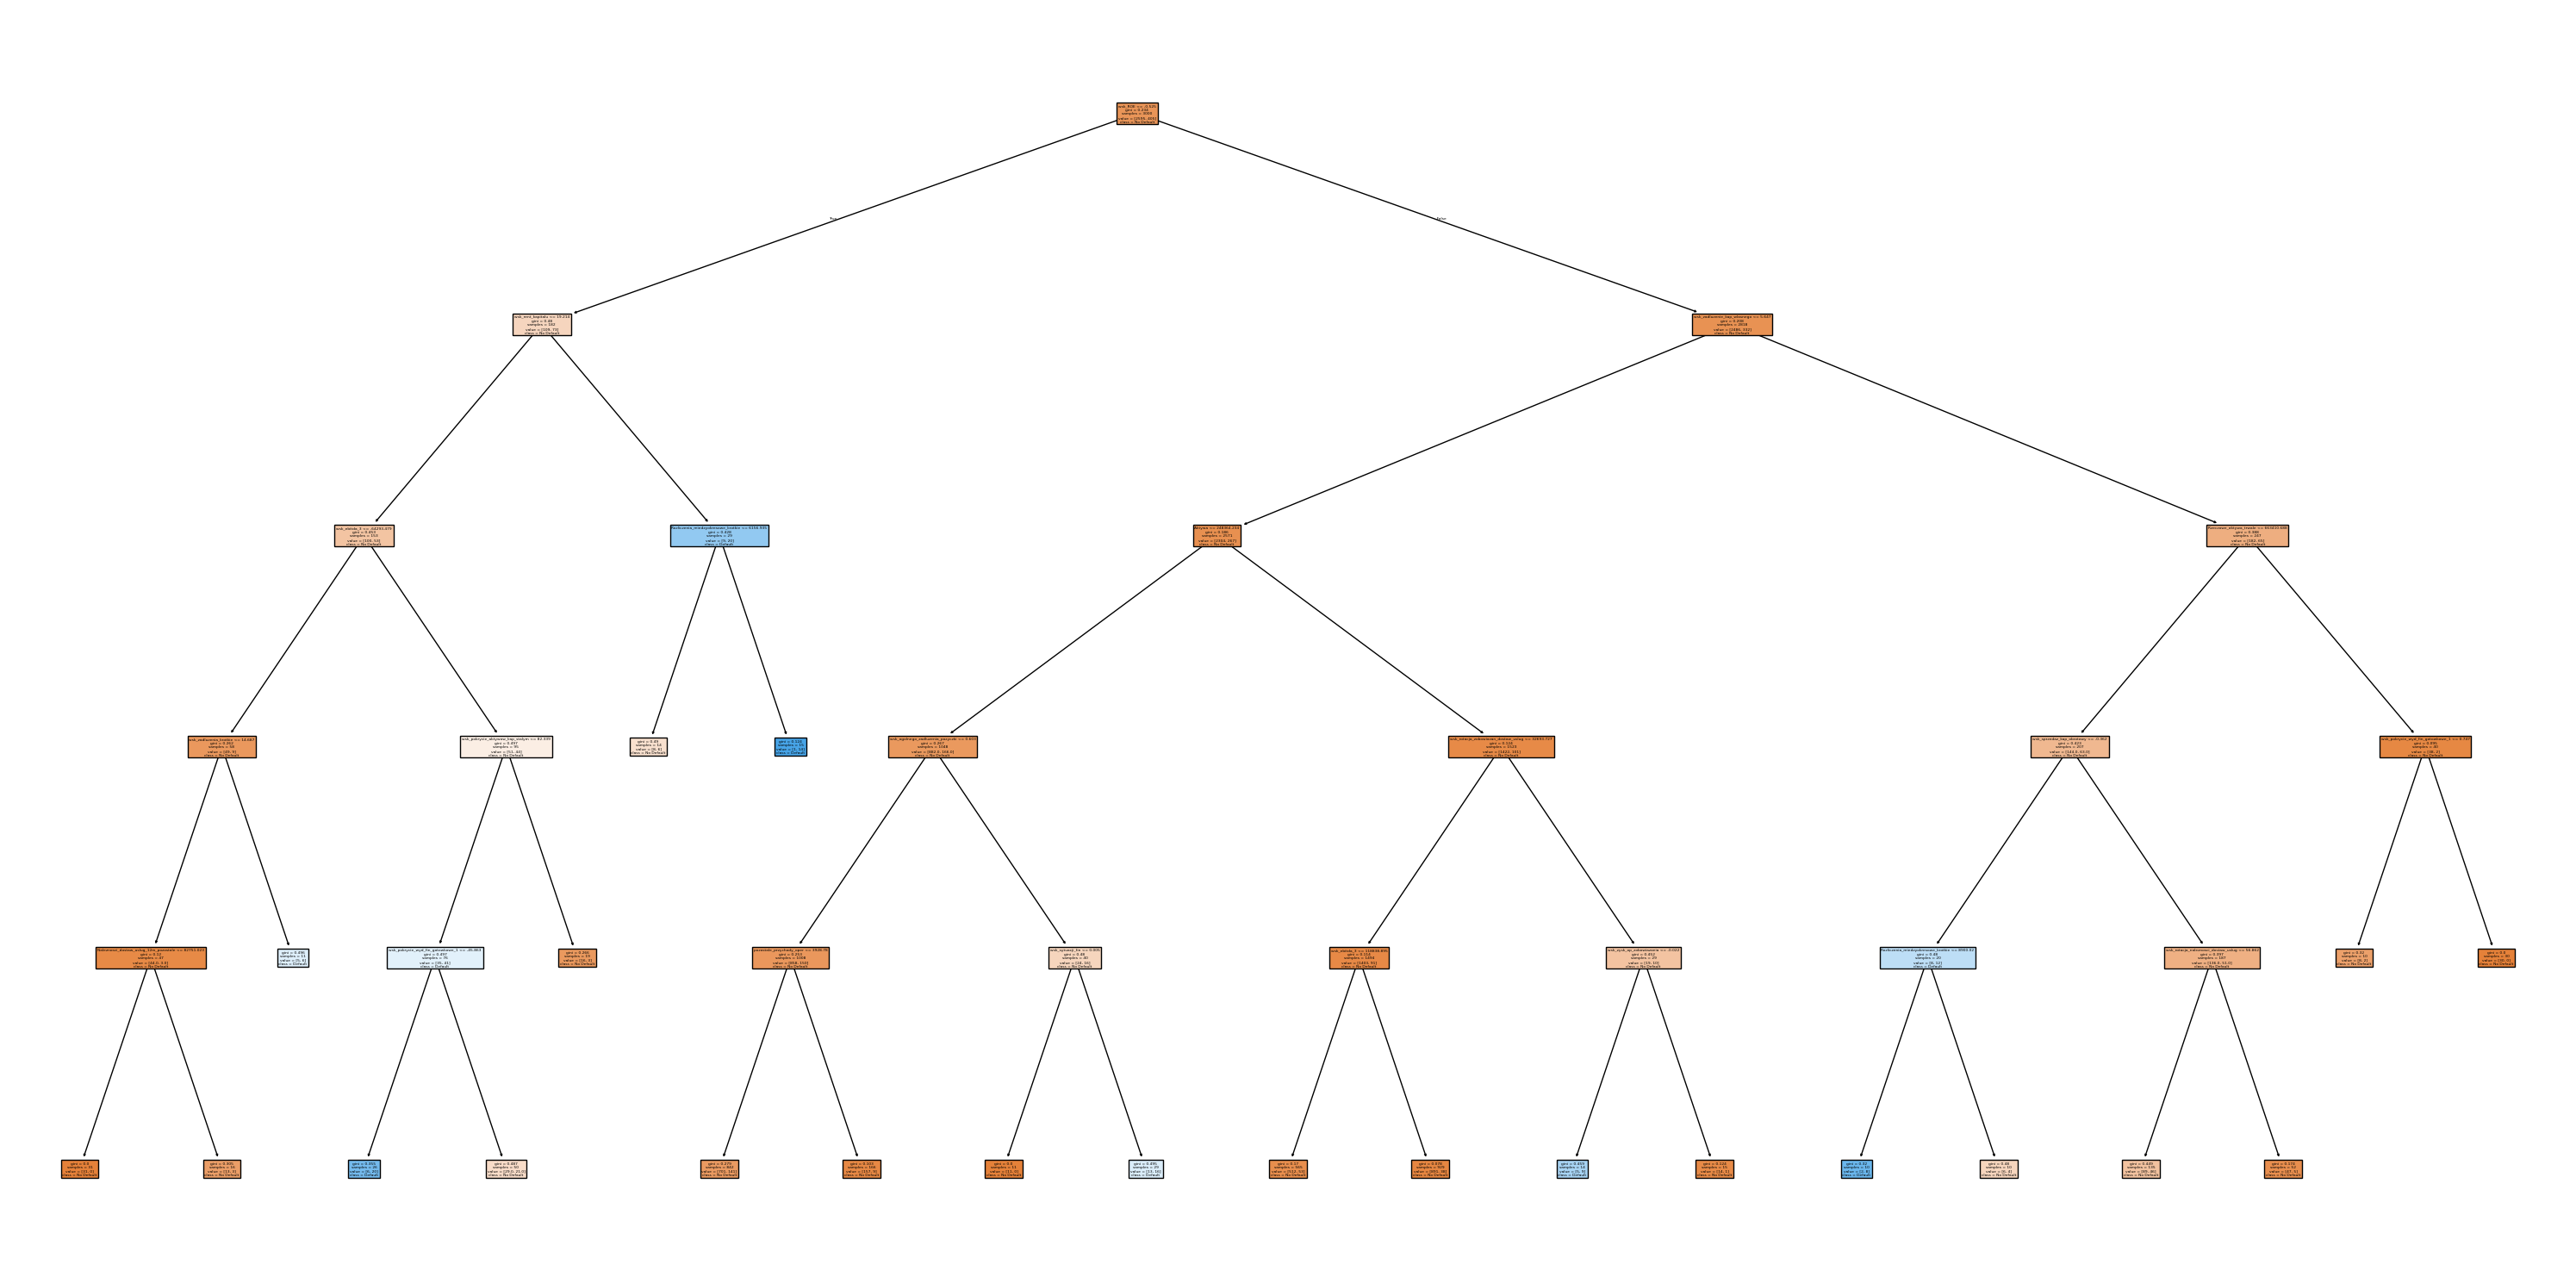

In [33]:
# Pobierz nazwy cech po transformacji
feature_names = (numeric_cols + 
                 pipe.named_steps['preprocessor']
                     .named_transformers_['cat']
                     .get_feature_names_out(categorical_cols).tolist())

plt.figure(figsize=(30, 15))  # Zwiększony rozmiar
plot_tree(pipe.named_steps['tree'], 
          feature_names=feature_names,
          class_names=['No Default', 'Default'],
          filled=True)       # Proporcjonalne rozmiary węzłów

plt.tight_layout()
plt.savefig('decision_tree.png', dpi=300, bbox_inches='tight')  # Zapisz w wysokiej rozdzielczości
plt.show()